In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls .

drive  sample_data


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/autocar/')

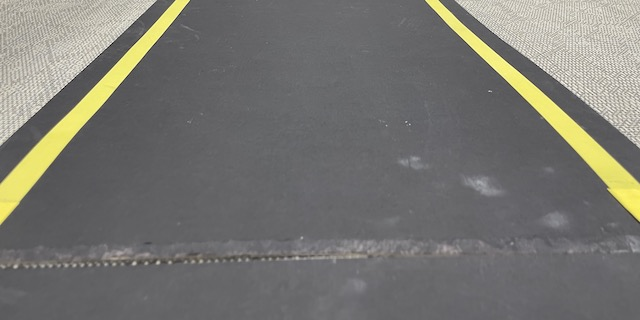

In [4]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
frame = cv2.imread('lane1.JPG')
cv2_imshow(frame)

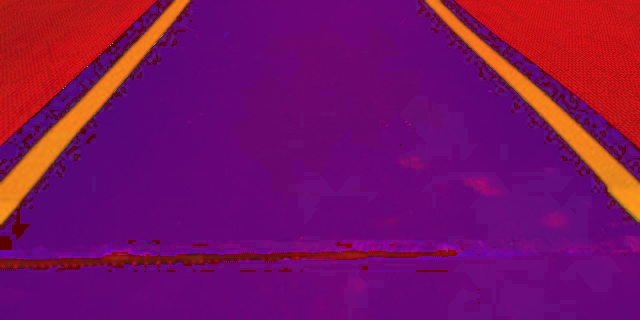

In [5]:
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
cv2_imshow(hsv)

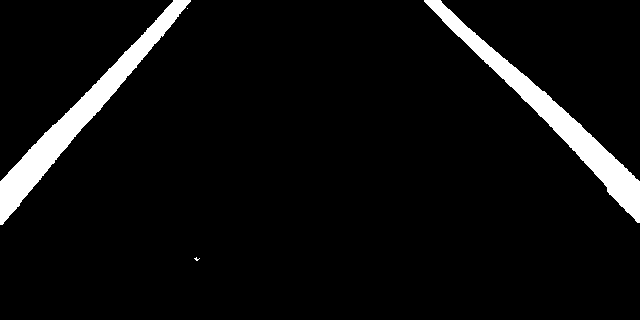

In [6]:
lower_blue = np.array([0, 40, 40])
upper_blue = np.array([150, 255, 255])
mask = cv2.inRange(hsv, lower_blue, upper_blue)
cv2_imshow(mask)

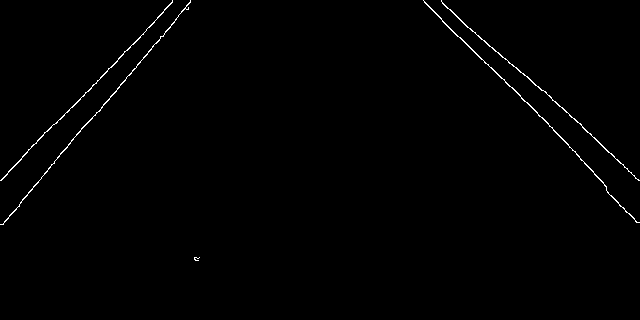

In [7]:
edges = cv2.Canny(mask, 200, 400)
cv2_imshow(edges)

In [8]:
def detect_edges(frame):
    cv2_imshow(frame)

    # filter for blue lane lines
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    cv2_imshow(hsv)

    lower_blue = np.array([0, 40, 40])
    upper_blue = np.array([150, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    cv2_imshow(mask)

    # detect edges
    edges = cv2.Canny(mask, 200, 400)
    cv2_imshow(edges)

    return edges

In [9]:
def region_of_interest(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)

    # only focus bottom half of the screen
    polygon = np.array([[
        (0, height * 1/2),
        (width, height * 1/2),
        (width, height),
        (0, height),
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    cropped_edges = cv2.bitwise_and(edges, mask)
    return cropped_edges

In [10]:
def detect_line_segments(cropped_edges):
    # tuning min_threashold, minLineLength, maxLineGap is a trial and error process by hand
    rho = 1 # distance precision in pixel, i.e. 1 pixel
    angle = np.pi / 180 # angular precision in radian, i.e. 1 degree
    min_threshold = 10
    line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold,
                                    np.array([]), minLineLength=8, maxLineGap=4)
    return line_segments

In [11]:
import logging
def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        print("No line_segment segments detected")
        return lane_lines
    
    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    boundary = 1/3
    left_region_boundary = width * (1 - boundary) # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = width * boundary # right lane line segment should be on left 2/3 of the screen

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                print(f'skipping vertical line segment (slope=inf): {line_segment}')
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))
    
    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))
    
    print(f'lane lines: {lane_lines}')

    return lane_lines

In [12]:
def make_points(frame, line):
    height, width, _ = frame.shape
    slope, intercept = line
    y1 = height # bottom of the frame
    y2 = int(y1 * 1 / 2) # make points from middle of the frame down

    # bound the coordiantes within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]

In [13]:
def detect_lane(frame):

    edges = detect_edges(frame)
    cropped_edges = region_of_interest(edges)
    line_segments = detect_line_segments(cropped_edges)
    lane_lines = average_slope_intercept(frame, line_segments)

    return lane_lines

In [14]:
def display_lines(frame, lines, line_color=(0, 255, 0), line_width=2):
    line_image = np.zeros_like(frame)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
    line_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    return line_image

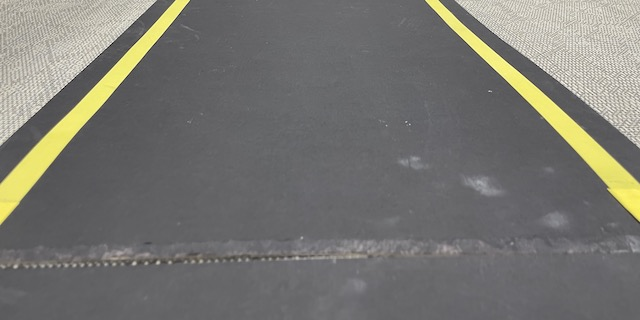

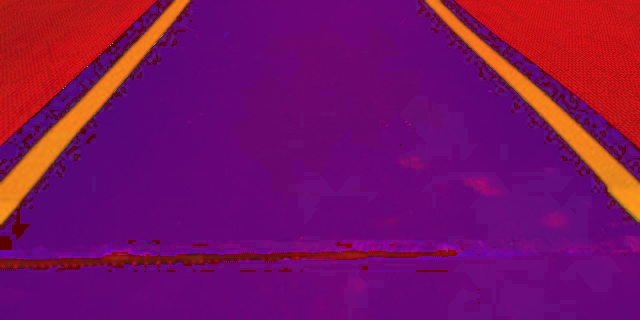

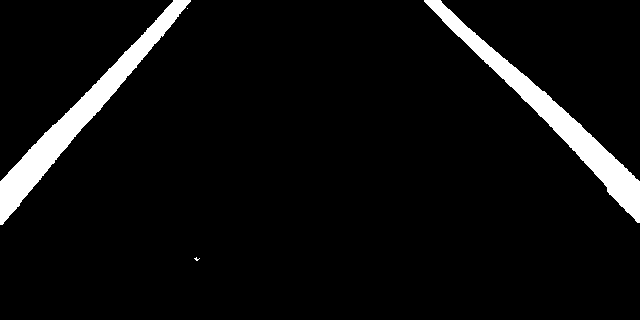

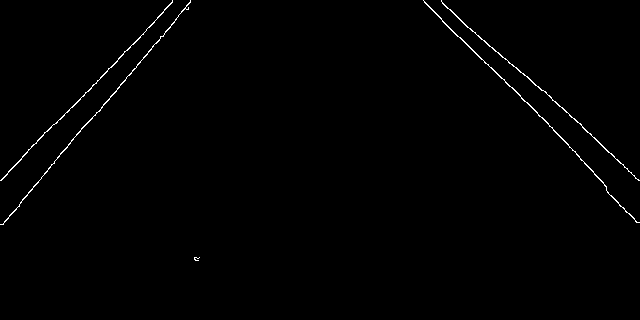

lane lines: [[[-97, 320, 45, 160]], [[744, 320, 585, 160]]]
89


In [15]:
import math
height, width, _ = frame.shape
lane_lines = detect_lane(frame)
_, _, left_x2, _ = lane_lines[0][0]
_, _, right_x2, _ = lane_lines[1][0]
mid = int(width/2)
x_offset = (left_x2 + right_x2) / 2 - mid
y_offset = int(height/2)
angle_to_mid_radian = math.atan(x_offset / y_offset) # angle (in radian) to center vertical line
angle_to_mid_deg = int(angle_to_mid_radian * 180.0 / math.pi) # angle (in degrees) to center vertical line
steering_angle = angle_to_mid_deg + 90 # this is the steering angle needed by picar front wheel
print(steering_angle)

In [ ]:
def display_heading_line(frame, steering_angle, line_color=(0, 0, 255), line_width=5):
    heading_image = np.zeros_like(frame)
    height, width, _ = frame.shape

    # figure out the heading line from steering angle
    # heading line (x1, y1) is always center bottom of the screen
    # (x2, y2) requires a bit of trigonometry

    # Note: the steering angle of:
    # 0-89 degree: turn left
    # 90 degree: going straight
    # 91-180 degree: turn right
    steering_angle_radian = steering_angle / 180.0 * math.pi
    x1 = int(width/2)
    y1 = height
    x2 = int(x1 - height / 2 / math.tan(steering_angle_radian))
    y2 = int(height / 2)

    cv2.line(heading_image, (x1, y1), (x2, y2), line_color, line_width)
    heading_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)

    return heading_image

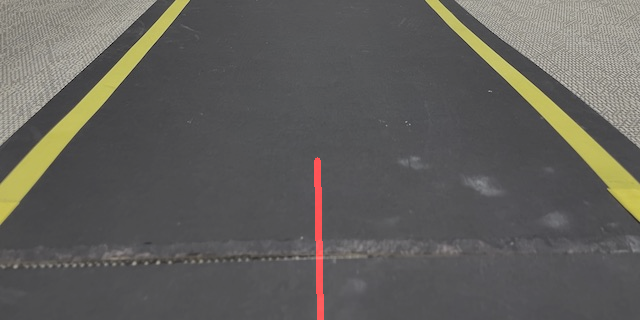

In [ ]:
heading_image = display_heading_line(frame, steering_angle)
cv2_imshow(heading_image)

In [ ]:
def stabilize_steering_angle(
    curr_steering_angle,
    new_steering_angle,
    num_of_lane_lines,
    max_angle_deviation_two_lines=5,
    max_angle_deviation_one_lane=1):
    """
    Using last steering angle to stabilize the steering angle
    if new angle is too different from current angle,
    only turn by max_angle_deviaion degrees
    """
    if num_of_lane_lines == 2:
        # if both lane lines detected, then we can deviate more
        max_angle_deviation = max_angle_deviation_two_lines
    else:
        # if only one lane detected, don't deviate too much
        max_angle_deviation = max_angle_deviation_one_lane
    
    angle_deviation = new_steering_angle - curr_steering_angle
    if abs(angle_deviation) > max_angle_deviation:
        stabilized_steering_angle = int(curr_steering_angle
                                        + max_angle_deviation * angle_deviation / abs(angle_deviation))
    else:
        stabilized_steering_angle = new_steering_angle
    return stabilized_steering_angle
    

In [ ]:
stabilize_steering_angle()

TypeError: ignored